In [3]:
import torch 
from torch.nn import Module
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.metrics import f1_score,accuracy_score



In [4]:
# df = pd.read_csv('C:/Users/louis/github_vs/archive/Submission.csv') Idk what this dataset is used for?
df = pd.read_csv('C:/Users/louis/github_vs/archive/fer2013/fer2013/fer2013.csv')

# some data formatting, returning the data in a tuple(img,label) form
def get_data(str):
    data = df[df["Usage"]==str]
    data_y = data['emotion'].reset_index(drop=True)
    # formatting form string to array of floats, of values in an [0,1] range, in an [1,48,48] shape
    data_x = data['pixels'].apply( lambda x : (np.array(x.split(" ")).astype('float')/255).reshape(-1,48,48))
    data_xy = [(x,y) for x,y in zip(data_y,data_x)]
    return data_xy

# loading the data in batches
batch_size = 16
trainloader = torch.utils.data.DataLoader(get_data("Training"), shuffle = False,batch_size = batch_size)
valloader = torch.utils.data.DataLoader(get_data("PublicTest"), shuffle = False,batch_size = batch_size)
testloader = torch.utils.data.DataLoader(get_data("PrivateTest"), shuffle = False,batch_size = batch_size)

# original class names, added manually, must be checked
class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']


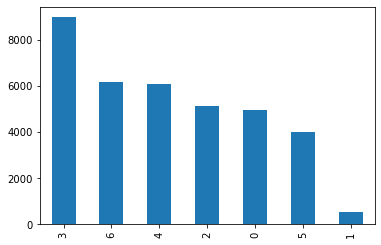

In [112]:
# checking for dataset imbalances
df['emotion'].value_counts().plot(kind = "bar")
# -> we must pay attention to class 1 (disgust)

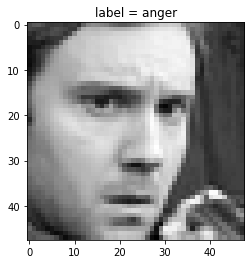

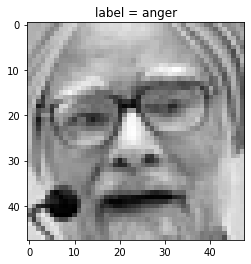

In [21]:
# showing some images, with their true labels
it = iter(trainloader)
out = it.next()
labels = out[0]
imgs= out[1]
for i in range(2):
    plt.figure()
    plt.imshow(imgs[i][0],cmap='gray')
    plt.title("label = "+class_names[labels[i]])

In [26]:
metrics =np.append(np.array([2,3]),np.array([4,5]))
print(metrics)

[2 3 4 5]


In [31]:
out_size = len(class_names);
scaler = 4 #scaling the number of channels form one con2d layer to another eg layer with SCALER channels -> layer with SCALER*2 channels
 
def update_size(input_size, filter,strides):
    return  input_size -int(np.floor((filter-2)/strides+1)) #formula can be found on https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

# building a customisable CNN sequential model
def build_model(order, filter_size, stride_size, pool_size, dropout_rate, scaler = scaler):
    
    input_size = 48 #keeping track of the different layer transformation on the size of the image
    layers = []
    
    # first layers
    layers.append(nn.Conv2d(in_channels =1, out_channels = scaler, kernel_size = filter_size, stride=stride_size))
    input_size = update_size(input_size,filter_size,stride_size)

    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
    input_size = update_size(input_size,pool_size,stride_size)
    
    # CNN stacked layers, order controls the number of layers added
    for i in range(1,order,2):
        layers.append(nn.Conv2d(scaler*i,scaler*(i+1), kernel_size = filter_size, stride=stride_size))
        input_size = update_size(input_size,filter_size,stride_size)
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(scaler*(i+1),scaler*(i+2), kernel_size = filter_size, stride=stride_size))
        input_size = update_size(input_size,filter_size,stride_size)
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
        input_size = update_size(input_size,pool_size,stride_size)

    # top classifier
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_size*input_size*scaler*(i+2),32)) # 32 is an artitrary number, must be greater than out_size
    layers.append(nn.Dropout(p =dropout_rate)) # adding some randomness in the weights
    layers.append(nn.ReLU())
    layers.append(nn.Flatten())
    layers.append(nn.Linear(32,out_size))     
    layers.append(nn.Softmax()) # prediction layer
    
    return  nn.Sequential(*layers)
# -----------------------------------------------

def train_model(model,epochs,lr,disp = True):  
    try:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        metrics = [np.array([]),np.array([]),np.array([]),np.array([])]
        # train loss, validation loss, validation accuracy, validation f1

        # training the model
        for epoch in range(0,epochs):
            train_loss = 0
            val_loss = 0

            for i, data in enumerate(trainloader): #iterating over the batches
                    inputs=data[1].float()
                    labels = data[0]
                    optimizer.zero_grad()
                    outputs = model(inputs) 
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss+=loss.item()
            model.eval()
            
            metrics[0] = np.append(metrics[0],train_loss/len(trainloader))
            
            all_labels = []; all_preds = []   
            for labels,imgs in valloader:
                preds = model(imgs.float())
                all_preds = np.append(all_preds,preds.argmax(dim=1).numpy())
                all_labels = np.append(all_labels,labels.detach().numpy())
                loss=criterion(preds,labels)

                val_loss+=loss.item()
            metrics[1] = np.append(metrics[1],val_loss/len(valloader))       
            metrics[2] = np.append(metrics[2],accuracy_score(all_labels,all_preds))
            metrics[3] = np.append(metrics[3],f1_score(all_labels,all_preds,average='macro'))
            
            if disp: print("epoch:",epoch,"train loss: ", metrics[0][len(metrics[0])-1], "val loss: ", metrics[1][len(metrics[1])-1], "val accuracy: ", metrics[2][len(metrics[2])-1], "val f1: ", metrics[3][len(metrics[3])-1])            
            return np.array(metrics)
    except:
        print("Error in training model")
        return metrics
    
# train_model(build_model(2,3,1,10,0.2),25,0.001)

In [29]:
# parameter tuning experiments:
lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
pool_sizes = [2,3,4,5,6,7,8]
stride_sizes = [1,2,3,4,5]
order = [2,4,6,8]
dropout_rates = [0.2,0.4,0.6,0.8]
scalers = [4,8,16,32,65]

In [33]:
lr_mets = []
for lr in lrs:
    print("lr: ",lr)
    model =build_model(2,3,1,10,0.2)
    mets = train_model(model,3,lr).T
    lr_mets.append(mets[len(mets)-1])
lr_mets   

lr:  0.0001
epoch: 0 train loss:  1.9482085596552134 val loss:  1.946944375567966 val accuracy:  0.1691278907773753 val f1:  0.041331880702710065
lr:  0.0005
epoch: 0 train loss:  1.9286343575852163 val loss:  1.9009835237926906 val accuracy:  0.24937308442463083 val f1:  0.05702816362941251
lr:  0.001
epoch: 0 train loss:  1.9014926807462007 val loss:  1.8936977545420328 val accuracy:  0.24937308442463083 val f1:  0.05702816362941251
lr:  0.005
epoch: 0 train loss:  1.9004374832828064 val loss:  1.897958247396681 val accuracy:  0.24937308442463083 val f1:  0.05702816362941251
lr:  0.01
epoch: 0 train loss:  1.898646098524747 val loss:  1.8967361402511598 val accuracy:  0.24937308442463083 val f1:  0.05702816362941251
lr:  0.05
epoch: 0 train loss:  1.9014983778212395 val loss:  1.8963184494442409 val accuracy:  0.24937308442463083 val f1:  0.05702816362941251
lr:  0.1
epoch: 0 train loss:  1.9142612501771337 val loss:  1.9162000709109837 val accuracy:  0.24937308442463083 val f1:  0.0

[array([1.94820856, 1.94694438, 0.16912789, 0.04133188]),
 array([1.92863436, 1.90098352, 0.24937308, 0.05702816]),
 array([1.90149268, 1.89369775, 0.24937308, 0.05702816]),
 array([1.90043748, 1.89795825, 0.24937308, 0.05702816]),
 array([1.8986461 , 1.89673614, 0.24937308, 0.05702816]),
 array([1.90149838, 1.89631845, 0.24937308, 0.05702816]),
 array([1.91426125, 1.91620007, 0.24937308, 0.05702816])]

Text(0, 0.5, 'Validation F1 Score')

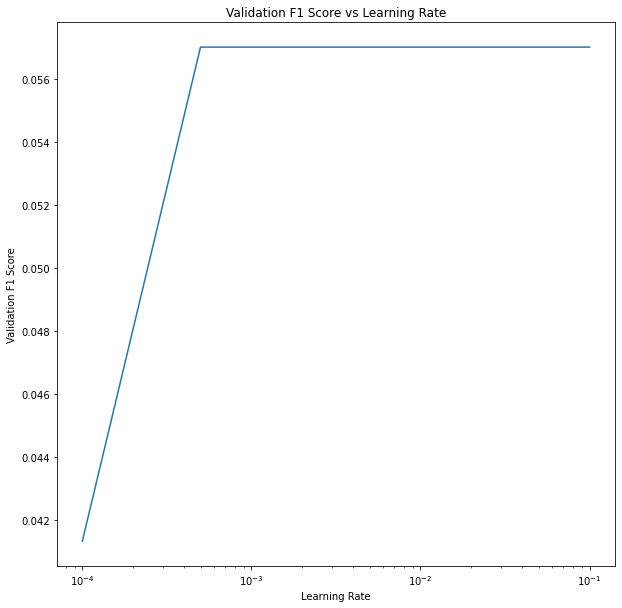

In [34]:
figure = plt.figure(figsize=(10,10))
plt.plot(lrs,np.array(lr_mets).T[3])
plt.semilogx()
plt.title('Validation F1 Score vs Learning Rate')
plt.xlabel("Learning Rate")
plt.ylabel("Validation F1 Score")


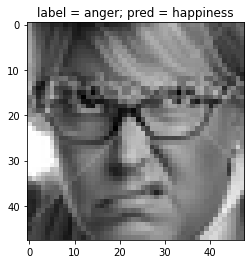

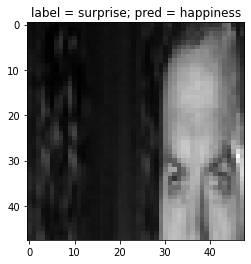

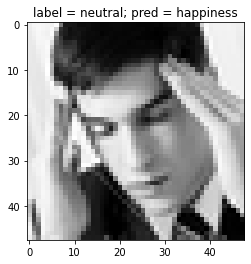

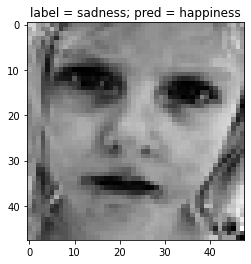

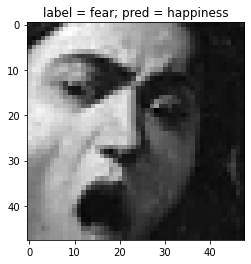

In [8]:
# printing some images with their predictions
it = iter(testloader)
out = it.next()
labels = out[0]
imgs= out[1]
preds = model(imgs.float()).argmax(dim=1).numpy()

for i in range(5):
    img = imgs[i][0]
    plt.figure()
    plt.imshow(img,cmap='gray')
    plt.title("label = "+class_names[labels[i]]+"; pred = "+class_names[preds[0]])
    
# the model is labelling everything with the majority class: happiness

In [7]:
# TODO Choose the best model

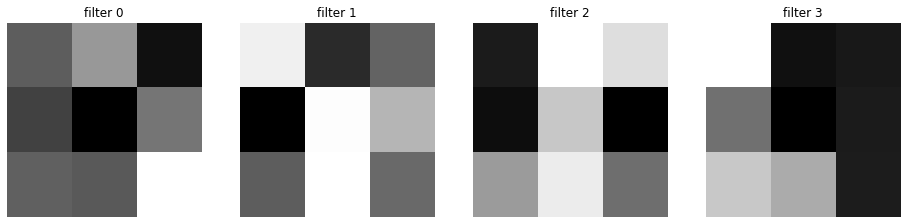

In [53]:
# Visualise the learned filters
# Display the relevant activations for different emotions

filters = model[0].weight.data.numpy()

plt.figure(figsize=(16, 8)) 
for i in range(filters.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(filters[i,0,:,:],cmap='gray')
    plt.axis('off')
    plt.title("filter "+str(i))

In [ ]:
# TODO test model on real life video, assess its quality